# Collaborative Filtering of Movies
## MSDS 7349 - Section 401
## Project 3

[Data Science @ Southern Methodist University](https://datascience.smu.edu/)

# Table of Contents
* [Team Members](#Team-Members)
* [Import Dataset](#Import)
* [Business Understanding](#Business-Understanding)
* [Data Understanding](#Data-Understanding)
* [Data Meaning](#Data-Meaning)
* [Data Visualization](#Data-Visualization)
* [Modeling and Evaluation](#Modeling-and-Evaluation)
* [Visualize Results](#Visualize-Results)
* [Summarize the Ramifications](#Summarize-the-Ramifications)
* [Deployment](#Deployment)
* [Exceptional Work](#Exceptional-Work)
* [References](#References)

# <a name="Team-Members"></a>Team Members
* [Jostein Barry-Straume](https://github.com/josteinstraume)
* [Kevin Cannon](https://github.com/kcannon2)
* [Ernesto Carrera Ruvalcaba](https://github.com/ecarrerasmu)
* [Adam Tschannen](https://github.com/adamtschannen)

# <a name="Import"></a>Import Dataset

In [1]:
%%capture
# Sources:
# https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb
# Supress output - https://stackoverflow.com/questions/23692950/how-do-you-suppress-output-in-ipython-notebook
# https://acodeforthought.wordpress.com/2016/12/26/building-a-simple-recommender-system-with-movie-lens-data-set/
import graphlab as gl
import matplotlib.pyplot as plt
import statistics as st
from graphlab import SFrame
import numpy as np
import pandas as pd
%matplotlib inline

filepath = '../data/ml-100k/ratings.csv'
dataCols = ['user_id', 'movie_id', 'rating', 'timestamp']
itemCols = ['movie_id', 'movie_title', 'release_date', 
            'video_release_date', 'IMDB_URL', 'unknown', 
            'action', 'adventure', 'animation', 'childrens',
            'comedy', 'crime', 'documentary', 'drama',
            'fantasy', 'film-noir', 'horror', 'musical',
            'mystery', 'romance', 'sci_fi', 'thriller',
            'war', 'western'          
           ]
userCols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

data = pd.read_csv('../data/ml-100k/u.data', sep = '\t', names = dataCols, encoding = 'latin-1')
item = pd.read_csv('../data/ml-100k/u.item', sep = '|', names = itemCols, encoding = 'latin-1')
user = pd.read_csv('../data/ml-100k/u.user', sep = '|', names = userCols, encoding = 'latin-1')

dataP = pd.merge(pd.merge(item, data), user)
dataP.to_csv('../data/pandas_dataframe.csv', encoding='latin-1')
dataS = gl.SFrame.read_csv('../data/pandas_dataframe.csv')



# <a name="Business-Understanding"></a>Business Understanding
*[10 points] Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?*

![xkcd: Machine Learning](../images/machine_learning.png)

* Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?)

> GroupLens is a research lab based out of the University of Minnesota's Department of Computer Science and Engineering. Part of the research lab's focus is in recommender systems. Consequently, GroupLens Research has collected this movie data because they offer a movie recommendation service while providing providing open-source data to the public for free. This dataset was found by our team in a Github Repository compiling publicly available datasets for recommender systems and machine learning. Afterwards we realized the very same dataset is endorsed in the syllabus as a good dataset to use for project 3. At first glance the data looked clean, offered variable sizing depending on the scope of the project, so we decided to proceed with utilizing GroupLens' data. 

* How will you measure the effectiveness of a good algorithm?

> The effectiveness of a good algorithm produced by this project will be measured with cross validation and evaluated in three ways; with Root Mean Squared Error (RMSE), per-user-recall, and per-user-precision.

> The first step in evaluating our algorithm via RMSE will be to calculate the average RMSE of every entry in the dataset using the following equation:

$$RMSE=\sqrt{\frac{1}{N}\sum_{i=1}^N (\hat{y}_i-y_i)^2}$$

> Afterwards, the RMSE for each user in the dataset will be calculated via:

$$\underbrace{RMSE(U)}_{\text{user=U}}=\sqrt{\frac{1}{|U|}\sum_{u\in U} (\hat{y}_u-y_u)^2}$$

> Additionally, the RMSE for each movie in the dataset will be calculated via:

$$\underbrace{RMSE(M)}_{\text{movie=M}}=\sqrt{\frac{1}{|M|}\sum_{m\in M} (\hat{y}_m-y_m)^2}$$

> The per-user-recall will be measured with the following equation:

$$R(k)=\frac{|a \cap p_k|}{|a|} $$

> Wherein $p_k$ is a vector of the $k$ highest ranked recommendations for a given user, and $a$ is the set of all positively ranked items for that given user in the test set.

> The per-user-precision will be measured with the following equation:

$$P(k)=\frac{|a \cap p_k|}{k} $$

> Wherein $p_k$ is a vector of the $k$ recommendations for a given user, and $a$ is the set of all positively ranked items for that given user in the test set.

* Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

> Potential vehicles in which to validate a given model are A/B testing, Root Mean Squared Error, recall, and precision. A/B testing is not feasible for this project because there is no way to test the model in a live setting. In other words, statistical hypothesis testing via click-rate and response rate cannot be measured in a real-word system because we are not privy to such an application. Fortunately, A/B testing is not the only way to evaluate a recommender system's quality.

> Root Mean Squared Error is one of the most commonly used methods to evaluate a recommender system. RMSE makes sense for the GroupLens movie ratings data because it was specifically collected with recommender systems in mind. In other words, the predicted movie recommendations will be compared to the actual movie recommendations. The GroupLens data even contains their own file of compiled recommendations with which one can carry out comparisons. By measuring general, per-user, and per-movie RMSE we will be able to discern the quality of a given model on a more granular level. Moreover, visualizing the array of averages produced by per-user and per-movie RMSE will provide a general macro overview of a given model. Additionally, statistical tests will be performed to comparatively evaluate models based on their respect RMSE values.

> Recall evaluation does have some limitations as not every user is going to rate all movies they watch. Most likely, users will only rate movies for which they have strong positive or negative feelings. However, per-user-recall is still relevant to the stakeholders needs as it us to answer the following question of interest: "of all the items rated positively by the user, how many did your recommender find?"

> By the same token, the limitations of precision evaluation are the same as those of recall evaluation. Fortunately, per-user-precision still makes sense for validating models for this specific dataset, and is still relevant to the stakeholders needs, because it allows us to answer the following question of interest:"of the k items found by your recommender, how many were rated positively by the user?"

> Much like per-user RMSE, statistical hypothesis tests will be used to for both recall and precision evaluation to comparatively discern the best performing models produced by in this project.

# <a name="Data-Understanding"></a>Data Understanding
*[10 points] Describe the meaning and type of data (scale, values, etc.) for each
attribute in the data file. Verify data quality: Are there missing values? Duplicate data?
Outliers? Are those mistakes? How do you deal with these problems?*

## <a name="Data-Meaning"></a>Data Meaning

* Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file

| Variable | Variable Type | Description |
| :------: | :-----------: | :---------: |
| userId | int | ID associated with a given user. Users were selected at random for inclusion and IDS have been anonymized.<br/>All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided. |
| movieId | int | ID associated with a given movie.<br/> The Movie IDs all contain "at least one rating or tag are included in the dataset"|
| rating | int | Ratings are made on a zero to 5-star scale, with half-star increments (0.5 stars - 5.0 stars).|
| timestamp | int | Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970. |
| title | str | Movie titles are entered manually or imported from <https://www.themoviedb.org/>, and include the year of release in parentheses.<br/> Errors and inconsistencies may exist in these titles. |
| genres | str| Genres are a pipe-separated list as a string, and are selected from the following:<br/>Action<br/>Adventure<br/>Animation<br/>Children's<br/>Comedy<br/>Crime<br/>Documentary<br/>Drama<br/>Fantasy<br/>Film-Noir<br/>Horror<br/>Musical<br/>Mystery<br/>Romance<br/>Sci-Fi<br/>Thriller<br/>War<br/>Western<br/>(no genres listed) |

>"This dataset (ml-20m) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.

>Users were selected at random for inclusion and IDS have been anonymized. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided."

>The Movie IDs all contain "at least one rating or tag are included in the dataset."

>The genres of movie are: Action,	Animation,	Comedy,	Drama,	Documentary, and Romance Short.

> As seen below, a call to the shape function verifies the number of observations, as well as attributes within the dataset:

In [2]:
dataP.shape

(100000, 31)

> Moreover, the summary statistics for each non-categorical variable are found below:

In [3]:
dataP.describe()

,movie_id,video_release_date,unknown,action,adventure,animation,childrens,comedy,crime,documentary,...,mystery,romance,sci_fi,thriller,war,western,user_id,rating,timestamp,age
count,100000.000000,0.0,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.00000,100000.000000,1.000000e+05,100000.000000
mean,425.530130,NaN,0.0001,0.255890,0.137530,0.036050,0.071820,0.298320,0.080550,0.007580,...,0.052450,0.194610,0.12730,0.21872,0.093980,0.018540,462.48475,3.529860,8.835289e+08,32.969850
std,330.798356,NaN,0.0100,0.436362,0.344408,0.186416,0.258191,0.457523,0.272144,0.086733,...,0.222934,0.395902,0.33331,0.41338,0.291802,0.134894,266.61442,1.125674,5.343856e+06,11.562623
min,1.000000,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1.00000,1.000000,8.747247e+08,7.000000
25%,175.000000,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,254.00000,3.000000,8.794487e+08,24.000000
50%,322.000000,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,447.00000,4.000000,8.828269e+08,30.000000
75%,631.000000,NaN,0.0000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,682.00000,4.000000,8.882600e+08,40.000000
max,1682.000000,NaN,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,943.00000,5.000000,8.932866e+08,73.000000


> Below one can see a brief snapshot of how the dataset appears:

In [4]:
dataP.head()

,movie_id,movie_title,release_date,video_release_date,IMDB_URL,unknown,action,adventure,animation,childrens,...,thriller,war,western,user_id,rating,timestamp,age,gender,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,1,0,0,308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,308,5,887736696,60,M,retired,95076


* Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

In [5]:
dataP.isnull().sum()

movie_id                   0
movie_title                0
release_date               9
video_release_date    100000
IMDB_URL                  13
unknown                    0
action                     0
adventure                  0
animation                  0
childrens                  0
comedy                     0
crime                      0
documentary                0
drama                      0
fantasy                    0
film-noir                  0
horror                     0
musical                    0
mystery                    0
romance                    0
sci_fi                     0
thriller                   0
war                        0
western                    0
user_id                    0
rating                     0
timestamp                  0
age                        0
gender                     0
occupation                 0
zip_code                   0
dtype: int64

In [6]:
# Source:
# https://stackoverflow.com/questions/29530232/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe
dataP.isnull().values.any()

True

> The two above cells of code verify the existence of missing or null values. Specifically, there are 9 null values for movie release date, 100,000 null values for video release date, and 13 null values for a given movie's IMDB URL link. However, these attributes are likely to be insignificant with regards to constructing a collaborative filtering recommender system. Now let's check if there exists any duplicate data:

In [7]:
# Source:
# https://stackoverflow.com/questions/9835762/how-do-i-find-the-duplicates-in-a-list-and-create-another-list-with-them
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html
import pandas as pd
dataP.duplicated().sum()

0

> Fortunately, there are no duplicated values within the dataset. Now let's check for outliers:

![Rating Boxplot](../images/rating_boxplot.png)

> A quick glance at the dashboard on GraphLab Canvas displays the distribution of values for the rating attribute. The green dot in the above boxplot is representing at least one outlier, since it is outside the lower whisker bound. We will delve deeper into the nature of outliers in the ensuing visualizing attributes section of this project. With that being said, outliers will not be removed from the dataset. The constructed recommender system has built-in functions for normalizing data to deal with such occurrences.

## <a name="Data-Visualization"></a>Data Visualization

*[10 points] Visualize the any important attributes appropriately. Important: Provide an
interpretation for any charts or graphs.*

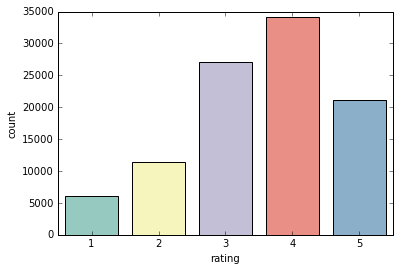

In [8]:
import seaborn as sns
sns.countplot(x="rating", data=dataP, palette="Set3")

> Histogram above displays the distribution of ratings within the dataset. It is visually apparent that the dataset, with regards to rating, is left-tail skewed and the most frequent rating is the value of 4. 

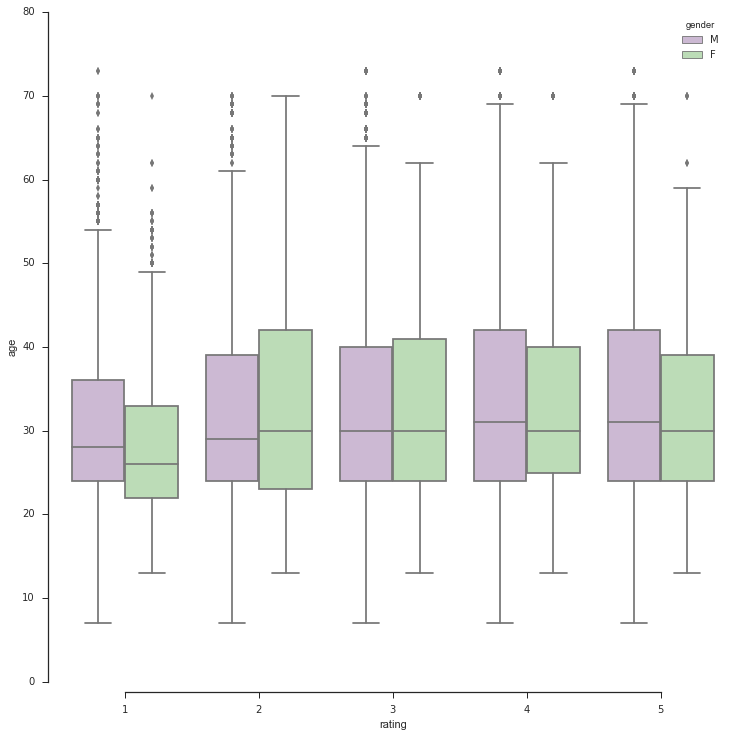

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(12, 12))
sns.boxplot(x="rating", y="age", hue="gender", data=dataP, palette="PRGn", ax=ax)
sns.despine(offset=10, trim=True)

### Visualizing important attributes

> The command "show" in Turi (excecuted below) automatically generates a graphical interface to visualize the data in an independent window browser. It is divided into 3 sections: "Summary", "Table", and "Plots". The "Summary" section shows the basic statistics of the variable. For the numeric variables, it creates box-whisker plots whereas for the categorical variables it generates a horizontal histogram displaying the label of the most frequent items. The "Table" part allows the user to easily navigate through the records of the dataset. Lastly, the component "Plots" enables the analysis of the relationship between 2 variables by generating customized charts. The user can plot the 2 variables using box-whisker, line chart, and a heat map.

>Looking into the first section "Summary", the description of the 6 variables in the dataset is as follows:

>1) userID: There are 669 unique users in our dataset. The total number of records is 100,004.

>2) movieID: The number of distinct movies is of 9,061.

>3) rating: This variable only takes 6 values, the integers from 0 to 5. The higher the rating the better the movie.

>4) timestamp: The different values for the dates is of 77,900.

>5) Title: There are 9,065 different titles in the dataset. The top 3 of the movies with the highest number of ratings are Forrest Gump, Pulp Fiction, and Shawshank.

>6) Genre: The movies can fall into different ranges. For example, a movie can be categorized as "Comedy and Romance". 

>The top 3 most frequent genres are: "Drama", "Comedy", and "Comedy & Romance". The total number of different combinations of genres is 904.

>Lastly, in section "Plots", the distribution of the rating indicates that the ratings are primarily concentrated in the grades of "3" and "4" and less concentrated in values of "0"

In [61]:
dataS.show()

In [62]:
dataP.shape

(100000, 32)

In [63]:
dataP['video_release_date'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: video_release_date, dtype: float64

In [64]:
dataP['timestamp'].head()

0    887736532
1    887737890
2    887739608
3    887738847
4    887736696
Name: timestamp, dtype: int64

In [13]:
dataP['release_date'].dtype

dtype('O')

In [14]:
dataP['release_date'].head()

0    01-Jan-1995
1    01-Jan-1995
2    01-Jan-1995
3    01-Jan-1995
4    01-Jan-1995
Name: release_date, dtype: object

In [15]:
dataP['release_date'].head()

0    01-Jan-1995
1    01-Jan-1995
2    01-Jan-1995
3    01-Jan-1995
4    01-Jan-1995
Name: release_date, dtype: object

In [16]:
dataP['datetime'] = pd.to_datetime(dataP['release_date'])
dataP['datetime'].dtype
dataP['datetime'].head()

0   1995-01-01
1   1995-01-01
2   1995-01-01
3   1995-01-01
4   1995-01-01
Name: datetime, dtype: datetime64[ns]

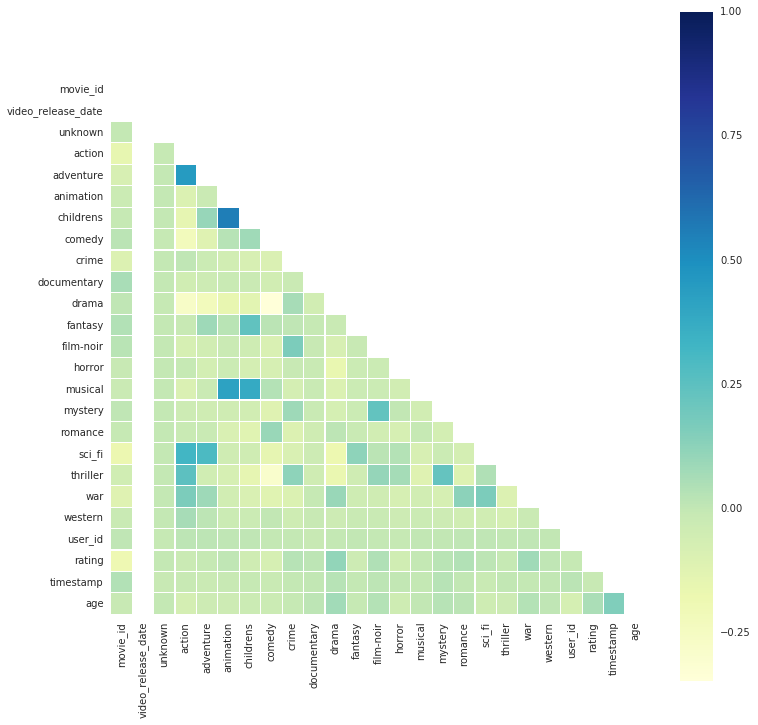

In [17]:
# Correlation heat map matrix
# Source:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
corr = dataP.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(12, 12))
    heatmap_corr = sns.heatmap(corr, mask=mask, square=True,
                                    linewidths=.1, cmap="YlGnBu")
    plt.savefig('../plots/heatmap_corr.png')

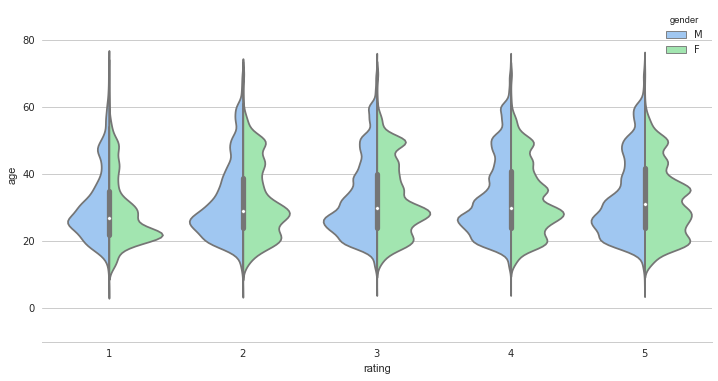

In [18]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid", palette="pastel", color_codes=True)
#ax = sns.violinplot(x="genre", y="rating", hue="SEX", data=dataP, split=True)
ax = sns.violinplot(x="rating", y="age", hue="gender", data=dataP, split=True)
sns.despine(left=True)
#plt.savefig('/Users/Jostein/Grad School/SMU/7331/project1/credit-default/'
#                + '/plots/violin-limitbalance-by-marriage-per-sex')

In [19]:
dataS.show()

Canvas is accessible via web browser at the URL: http://localhost:52629/index.html
Opening Canvas in default web browser.


# <a name="Modeling-and-Evaluation"></a>Modeling and Evaluation
*Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results. Each option is broken down by:*

## Train and adjust parameters

## User-Item Recommendation System

In [20]:
dataS.head()

X1,movie_id,movie_title,release_date,video_release_date,IMDB_URL,unknown
0,1,Toy Story (1995),01-Jan-1995,,http://us.imdb.com/M/title-exact?Toy%20St ...,0
1,4,Get Shorty (1995),01-Jan-1995,,http://us.imdb.com/M/title-exact?Get%20Sh ...,0
2,5,Copycat (1995),01-Jan-1995,,http://us.imdb.com/M/title- ...,0
3,7,Twelve Monkeys (1995),01-Jan-1995,,http://us.imdb.com/M/title-exact?Twelve%2 ...,0
4,8,Babe (1995),01-Jan-1995,,http://us.imdb.com/M/title- ...,0
5,9,Dead Man Walking (1995),01-Jan-1995,,http://us.imdb.com/M/title-exact?Dead%20M ...,0
6,11,Seven (Se7en) (1995),01-Jan-1995,,http://us.imdb.com/M/title- ...,0
7,12,"Usual Suspects, The(1995) ...",14-Aug-1995,,http://us.imdb.com/M/title-exact?Usual%20 ...,0
8,15,Mr. Holland's Opus (1995),29-Jan-1996,,http://us.imdb.com/M/title-exact?Mr.%20Ho ...,0
9,17,From Dusk Till Dawn(1996) ...,05-Feb-1996,,http://us.imdb.com/M/title-exact?From%20D ...,0


In [21]:
import graphlab as gl
model = gl.recommender.create(dataS, user_id="user_id", item_id="movie_id", target="rating")
results = model.recommend(users=None, k=5)
model.save("my_model")

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 97914 observations with 925 users and 1679 items.

Data prepared in: 0.57263s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 12239 / 97914 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.6129            | Not Viable                               |

| 1       | 0.403226          | Not Viable                               |

| 2       | 0.100806          | 1.63796                                  |

| 3       | 0.0504032         | 1.14377                                  |

| 4       | 0.0252016         | 0.904692                                 |

| 5       | 0.0126008         | 1.58242                                  |

| 6       | 0.0063004         | 1.85916                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0252016         | 0.904692                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 3.553ms      | 2.48401           | 1.12557               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 687.13ms     | 1.71721           | 1.07192               | 0.0252016   |

| 2       | 1.35s        | 1.35365           | 0.991138              | 0.0252016   |

| 3       | 2.02s        | 1.17891           | 0.947578              | 0.0252016   |

| 4       | 2.66s        | 1.06817           | 0.915645              | 0.0252016   |

| 5       | 3.32s        | 0.996907          | 0.894592              | 0.0252016   |

| 6       | 3.94s        | 0.946782          | 0.879384              | 0.0252016   |

| 10      | 6.38s        | 0.832962          | 0.839278              | 0.0252016   |

| 11      | 6.98s        | 0.812612          | 0.831287              | 0.0252016   |

| 15      | 9.27s        | 0.755896          | 0.808893              | 0.0252016   |

| 20      | 12.52s       | 0.710242          | 0.788324              | 0.0252016   |

| 25      | 15.43s       | 0.679541          | 0.774455              | 0.0252016   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.664214

Final training RMSE: 0.762756

In [22]:
results # the recommendation output

user_id,movie_id,score,rank
308,173,5.05790894614,1
308,228,4.67782842504,2
308,150,4.55119080232,3
308,431,4.50538005071,4
308,188,4.48082973199,5
287,174,5.47385107862,1
287,408,5.29597821222,2
287,197,5.28053268181,3
287,265,5.26796534048,4
287,523,5.23341354119,5


## Item-Item Recommendation System

In [23]:
item_item = gl.recommender.item_similarity_recommender.create(dataS, 
                                  user_id="user_id", 
                                  item_id="movie_title", 
                                  target="rating",
                                  only_top_k=3,
                                  similarity_type="cosine")

results = item_item.get_similar_items(k=3)
results.head()

Recsys training: model = item_similarity

Warning: Ignoring columns X1, movie_id, release_date, video_release_date, IMDB_URL, unknown, action, adventure, animation, childrens, comedy, crime, documentary, drama, fantasy, film-noir, horror, musical, mystery, romance, sci_fi, thriller, war, western, timestamp, age, gender, occupation, zip_code;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 97914 observations with 925 users and 1661 items.

Data prepared in: 0.123017s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.572ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 10.502ms                            | 0.75             | 13              |

| 57.532ms                            | 100              | 1661            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.064661s

movie_title,similar,score,rank
Toy Story (1995),Star Wars (1977),0.731784462929,1
Toy Story (1995),Return of the Jedi (1983),0.697239160538,2
Toy Story (1995),Independence Day (ID4)(1996) ...,0.687915802002,3
Get Shorty (1995),Pulp Fiction (1994),0.648687839508,1
Get Shorty (1995),Back to the Future (1985),0.631140470505,2
Get Shorty (1995),Raiders of the Lost Ark(1981) ...,0.630040228367,3
Copycat (1995),Cape Fear (1991),0.540185034275,1
Copycat (1995),Outbreak (1995),0.464888572693,2
Copycat (1995),"Nightmare on Elm Street,A (1984) ...",0.457200467587,3
Twelve Monkeys (1995),Fargo (1996),0.689777255058,1


In [24]:
train, test = gl.recommender.util.random_split_by_user(dataS,
                                                    user_id="user_id", item_id="movie_id",
                                                    max_num_users=100, item_test_proportion=0.2, random_seed=1)

In [48]:
from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')


item_item = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="user_id", 
                                  item_id="movie_id", 
                                  target="rating",
                                  only_top_k=5,
                                  similarity_type="cosine")

rmse_results_item = item_item.evaluate(test)

Recsys training: model = item_similarity

Warning: Ignoring columns X1, movie_title, release_date, video_release_date, IMDB_URL, unknown, action, adventure, animation, childrens, comedy, crime, documentary, drama, fantasy, film-noir, horror, musical, mystery, romance, sci_fi, thriller, war, western, timestamp, age, gender, occupation, zip_code;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 95765 observations with 925 users and 1677 items.

Data prepared in: 0.09209s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.882ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 9.458ms                             | 0                | 2               |

| 64.047ms                            | 100              | 1677            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.071922s


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.49      | 0.0349076130698 |
|   2    |      0.53      | 0.0824669301669 |
|   3    |      0.49      |  0.111536627534 |
|   4    |     0.4525     |  0.136823771039 |
|   5    |     0.416      |  0.147925008089 |
|   6    |     0.405      |  0.171381859988 |
|   7    |      0.38      |  0.18146161008  |
|   8    |    0.36625     |  0.195038959544 |
|   9    | 0.353333333333 |  0.208695957778 |
|   10   |     0.341      |  0.221058194103 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 3.5936694035490335)

Per User RMSE (best)
+---------+-------+---------------+
| user_id | count |      rmse     |
+---------+-------+---------------+
|   724   |   19  | 2.42521383674 |
+---------+-------+---------------+
[1 rows x 3 columns]


Per User RMSE (w

In [49]:
print rmse_results_item.viewkeys()

dict_keys(['rmse_by_user', 'precision_recall_overall', 'rmse_by_item', 'precision_recall_by_user', 'rmse_overall'])


In [50]:
rmse_results_item['rmse_by_user']

user_id,count,rmse
786,25,3.71869638022
516,5,3.68582684054
465,12,3.75839468645
376,7,3.88064945113
193,26,3.35525918877
810,5,4.25467312815
336,24,3.40201023193
176,7,3.79166489805
407,48,3.64627422479
214,19,3.8486400219


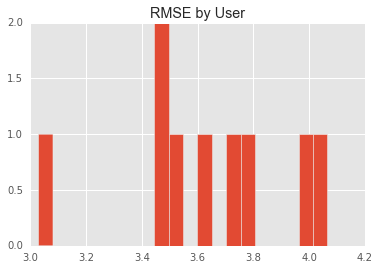

In [51]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

rmsevals = rmse_results_item['rmse_by_user']['rmse']
rmsevals = rmsevals[rmse_results_item['rmse_by_user']['count']>50]

plt.hist(rmsevals,bins=20)
plt.title('RMSE by User')
plt.show()

In [52]:
rmse_results_item['precision_recall_by_user']

user_id,cutoff,precision,recall,count
1,1,1.0,0.0188679245283,53
1,2,1.0,0.0377358490566,53
1,3,0.666666666667,0.0377358490566,53
1,4,0.75,0.0566037735849,53
1,5,0.8,0.0754716981132,53
1,6,0.666666666667,0.0754716981132,53
1,7,0.714285714286,0.0943396226415,53
1,8,0.625,0.0943396226415,53
1,9,0.555555555556,0.0943396226415,53
1,10,0.5,0.0943396226415,53


## Cross Validated Collaborative Filtering

> By condensing the dimensionality of the user-item matrix we are attempting to capture the generalizations that are contained within the data. In other words, dimension reduction via factorization will attempt to capture "latent patterns" that occur between users and the movies they have rated.

In [46]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="user_id", 
                                  item_id="movie_id", 
                                  target="rating")

rmse_results = rec1.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 95765 observations with 925 users and 1677 items.

Data prepared in: 0.492385s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11970 / 95765 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.6129            | Not Viable                               |

| 1       | 0.403226          | Not Viable                               |

| 2       | 0.100806          | 0.278882                                 |

| 3       | 0.0504032         | 0.457041                                 |

| 4       | 0.0252016         | 1.05447                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.100806          | 0.278882                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 98us         | 2.48464           | 1.12555               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 902.296ms    | DIVERGED          | DIVERGED              | 0.100806    |

| RESET   | 1.18s        | 2.48378           | 1.12557               |             |

| 1       | 1.99s        | 1.5097            | 1.06353               | 0.0504032   |

| 2       | 2.69s        | 0.986529          | 0.906702              | 0.0504032   |

| 3       | 3.35s        | 0.820153          | 0.843043              | 0.0504032   |

| 4       | 4.01s        | 0.732519          | 0.804587              | 0.0504032   |

| 5       | 4.66s        | 0.676156          | 0.777683              | 0.0504032   |

| 6       | 5.30s        | 0.637209          | 0.757814              | 0.0504032   |

| 9       | 7.09s        | 0.563268          | 0.717457              | 0.0504032   |

| 11      | 8.26s        | 0.533201          | 0.700181              | 0.0504032   |

| 14      | 9.99s        | 0.500192          | 0.680174              | 0.0504032   |

| 19      | 12.87s       | 0.462969          | 0.65641               | 0.0504032   |

| 24      | 15.99s       | 0.438509          | 0.640055              | 0.0504032   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.415669

Final training RMSE: 0.621579


Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean_precision |   mean_recall    |
+--------+----------------+------------------+
|   1    |      0.2       | 0.00920171132449 |
|   2    |     0.195      | 0.0180245014757  |
|   3    |      0.18      | 0.0235739925242  |
|   4    |     0.1625     | 0.0281352577262  |
|   5    |     0.158      | 0.0342182068187  |
|   6    | 0.151666666667 | 0.0398803773343  |
|   7    | 0.142857142857 |  0.044368675411  |
|   8    |    0.13875     | 0.0530120799204  |
|   9    | 0.133333333333 | 0.0585433579918  |
|   10   |     0.132      | 0.0631493975212  |
+--------+----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.0095544223807171)

Per User RMSE (best)
+---------+-------+----------------+
| user_id | count |      rmse      |
+---------+-------+----------------+
|   772   |   3   | 0.292320739323 |
+---------+-------+----------------+
[1 rows x 3 columns]

In [47]:
import graphlab.aggregate as agg
rmse_results['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')])

cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
16,0.125,0.150779226023,0.0963136636224,0.108840621087
10,0.132,0.166060230037,0.0631493975212,0.0880872590733
36,0.0977777777778,0.114158218125,0.155950873908,0.136178160666
26,0.110384615385,0.131969043349,0.1275552003,0.126388148216
41,0.0921951219512,0.105165799242,0.16906267494,0.138414268604
3,0.18,0.284487843911,0.0235739925242,0.0438055431648
1,0.2,0.4,0.00920171132449,0.028334732703
6,0.151666666667,0.208293329493,0.0398803773343,0.0613258552086
11,0.131818181818,0.164831494222,0.072915317771,0.0996242749411
2,0.195,0.307367857786,0.0180245014757,0.0359023962553


> After taking a look at the aggregation we find the cut off of 16 is the best. What this means is that if you recommend 16 movies to every user you will accurately recommend the correct movie 13% of the time with a standard deviation of .14. This is the best because it has the highest average precision relive to the standard deviation. In contrast, when we see 1 movie recommend it has average precision of 23% but it has a very high standard deviation of .42. This is because if you only recommend 1 movie you are either 100% correct or 0% correct.

> Now let's adjust the parameters in our cross-validation model to see if the resulting user-item recommender system can perform better. We will run the model again, but this time invoking three optional parameters within the recommender function.

> Firstly, num_factors input parameter will be set to the value of 16. By increasing the num_factor value, we are increasing the importance of these latency factors. In other words, we are amplifying the user's biases to capitalize on general trends within the rating system. Simply put, "if a user tends to love romance movies and hate action movies, the factor terms attempt to capture that, causing the model to predict lower scores for action movies and higher scores for romance movies" [Source](https://turi.com/products/create/docs/generated/graphlab.recommender.ranking_factorization_recommender.RankingFactorizationRecommender.html).

> Secondly, the regularization input parameter will be set to the value of 1e-02. Invoking the regularization parameter will hopefully result in a more accurate model. With this in mind, the linear_regularization input parameter will be set to 1e-3 for similar reasons. These regularization terms are influencing help our model use underlying pattern found in the data.

> Additionally, introducing regularization terms into the model will avoid over-fitting. As a result, a more accurate and precise model should be created.

In [32]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="user_id", 
                                  item_id="movie_id", 
                                  target="rating",
                                  num_factors=16,                 # override the default value
                                  regularization=1e-02,           # override the default value
                                  linear_regularization = 1e-3)   # override the default value

rmse_results_regularized = rec1.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 95765 observations with 925 users and 1677 items.

Data prepared in: 0.450685s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11970 / 95765 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0769116         | 1.91537                                  |

| 1       | 0.0384558         | 1.92132                                  |

| 2       | 0.0192279         | 2.01823                                  |

| 3       | 0.00961395        | 2.08392                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0769116         | 1.91537                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 99us         | 2.48463           | 1.12554               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 493.995ms    | 2.20596           | 1.08718               | 0.0769116   |

| 2       | 966.503ms    | 2.04155           | 1.07039               | 0.0769116   |

| 3       | 1.42s        | 1.95616           | 1.04696               | 0.0769116   |

| 4       | 3.40s        | 1.93159           | 1.03801               | 0.0769116   |

| 5       | 3.87s        | 1.92753           | 1.03404               | 0.0769116   |

| 6       | 4.36s        | 1.92401           | 1.0291                | 0.0769116   |

| 10      | 6.23s        | 1.92358           | 1.02423               | 0.0769116   |

| 11      | 6.71s        | 1.92369           | 1.02317               | 0.0769116   |

| 15      | 8.87s        | 1.9217            | 1.02288               | 0.0769116   |

| 20      | 11.63s       | 1.92242           | 1.02242               | 0.0769116   |

| 25      | 14.09s       | 1.92061           | 1.02145               | 0.0769116   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.9487

Final training RMSE: 1.01534


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.41      | 0.0245176382872 |
|   2    |     0.295      | 0.0323091534557 |
|   3    | 0.256666666667 | 0.0432480131879 |
|   4    |     0.2325     | 0.0480254797209 |
|   5    |     0.214      | 0.0538471854784 |
|   6    |     0.195      | 0.0568326121534 |
|   7    | 0.195714285714 | 0.0665445114345 |
|   8    |    0.19125     |  0.073653840332 |
|   9    |      0.19      |  0.081337962443 |
|   10   |     0.184      | 0.0857256295173 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.0263688824394601)

Per User RMSE (best)
+---------+-------+----------------+
| user_id | count |      rmse      |
+---------+-------+----------------+
|   516   |   5   | 0.245116586351 |
+---------+-------+----------------+
[1 rows x 3 columns]


Per User RM

In [33]:
import graphlab.aggregate as agg
rmse_results_regularized['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')])

cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
16,0.168125,0.18639151503,0.125730281467,0.116557941542
10,0.184,0.204313484626,0.0857256295173,0.0859471683947
36,0.133333333333,0.13955396319,0.232180700065,0.152707956537
26,0.15,0.157504578688,0.196073941529,0.138612010238
41,0.128780487805,0.130940859268,0.266387717821,0.161786112443
3,0.256666666667,0.301311946144,0.0432480131879,0.0687109385191
1,0.41,0.491833305094,0.0245176382872,0.0442796602714
6,0.195,0.224913563644,0.0568326121534,0.0717021520492
11,0.179090909091,0.205082124248,0.0903645379645,0.0918493980565
2,0.295,0.347095087836,0.0323091534557,0.0493426833448


> In comparison to before introducing regularization terms, our new model has a higher average precision as well as a lower standard deviation of precision. In addition, it's average recall is higher with a lower standard deviation. Based on these metrics, we have created a better performing model with the addition of these new parameters.

* RMSE before regularization parameters: 0.978076840491603
* RMSE with regularization parameters: 1.0353293256561886

> It is important to note that the Root Mean Squared Error (RMSE) has increased by introducing regularization parameters into the model. However, RMSE is only increasing by approximately 0.057. As a result, we are trading a little higher RMSE, and in exchange receiving higher precision, higher recall, and both with lower variance respectively.

## Evaluate and Compare

In [36]:
comparison = gl.recommender.util.compare_models(test, [item_item, rec1])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.49      | 0.0349076130698 |
|   2    |      0.53      | 0.0824669301669 |
|   3    |      0.49      |  0.111536627534 |
|   4    |     0.4525     |  0.136823771039 |
|   5    |     0.416      |  0.147925008089 |
|   6    |     0.405      |  0.171381859988 |
|   7    |      0.38      |  0.18146161008  |
|   8    |     0.365      |  0.194795057105 |
|   9    | 0.353333333333 |  0.208695957778 |
|   10   |     0.342      |  0.222486765532 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 3.5937395449421956)

Per User RMSE (best)
+---------+-------+---------------+
| user_id | count |      rmse     |
+---------+-------+---------------+
|   724   |   19  | 2.42521383674 |
+---------+-------+---------------+
[1 rows x 3

In the comparison above, our item_item model has a higher mean precision and mean recall than our cross validation model. However, the RMSE of our cross validation model is 1.026 which less than a third of the item_item recommender’s RMSE of 3.59. This means the item_item model is better at correctly recommending movies but not as good as correctly predicting the exact rating the user will rate the movie. Based on the above, the item_item model is better model because we value the ability to recommend a movie the user will like over trying to predict what the rating is the user will give that movie.

In [40]:
gl.show_comparison(comparisonstruct,[item_item, rec1])

In [54]:
import graphlab.aggregate as agg
rmse_results_item['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')])

cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
16,0.28875,0.206113591255,0.290032987602,0.19147232387
10,0.341,0.247424736031,0.221058194103,0.180108732258
36,0.202777777778,0.162849813412,0.421973498085,0.206924941335
26,0.235384615385,0.182299577878,0.364865701381,0.203286475144
41,0.189024390244,0.15345999562,0.440353465402,0.210866257067
3,0.49,0.363486206371,0.111536627534,0.134386632663
1,0.49,0.499899989998,0.0349076130698,0.0690269774798
6,0.405,0.286991095487,0.171381859988,0.171263755684
11,0.328181818182,0.244913545212,0.230191649728,0.184263259535
2,0.53,0.398873413504,0.0824669301669,0.107971471739


In [55]:
rmse_results_regularized['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')])

cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
16,0.168125,0.18639151503,0.125730281467,0.116557941542
10,0.184,0.204313484626,0.0857256295173,0.0859471683947
36,0.133333333333,0.13955396319,0.232180700065,0.152707956537
26,0.15,0.157504578688,0.196073941529,0.138612010238
41,0.128780487805,0.130940859268,0.266387717821,0.161786112443
3,0.256666666667,0.301311946144,0.0432480131879,0.0687109385191
1,0.41,0.491833305094,0.0245176382872,0.0442796602714
6,0.195,0.224913563644,0.0568326121534,0.0717021520492
11,0.179090909091,0.205082124248,0.0903645379645,0.0918493980565
2,0.295,0.347095087836,0.0323091534557,0.0493426833448


In the above tables, we can see the item_item model has a higher average percision and average recall than our regularizaed model. However, the item_item model has a higher standard deviation meaning it is more volitile even though its average may be more accurate. The regularized user_item model is more consistent in its recommendations, at the cost of a lower precision and recall. In contrast, the item_item model is more accurate overall but at the cost of its consistency with regards to which movies are recommended.

A model that minimizes both biases and variance is ideal. However, it a real-world setting we often have to make compromises. Perhaps in a deployment scenario, Netflix would prefer the model that is more consistency, while Amazon is okay with recommending a large span of movies.


In [61]:
%%capture
params = {'user_id': 'user_id', 
          'item_id': 'movie_id', 
          'target': 'rating',
          'num_factors': [8, 12, 16, 24, 32], 
          'regularization':[0.001] ,
          'linear_regularization': [0.001]}

job = gl.model_parameter_search.create( (train,test),
        gl.recommender.ranking_factorization_recommender.create,
        params,
        max_models=10,
        environment=None)

In [62]:
job.get_status()

{'Canceled': 0, 'Completed': 0, 'Failed': 0, 'Pending': 0, 'Running': 10}

In [63]:
job_result = job.get_results()

job_result.head()

model_id,item_id,linear_regularization,max_iterations,num_factors,num_sampled_negative_examples ...,ranking_regularization
9,movie_id,0.001,50,24,4,0.5
8,movie_id,0.001,25,12,4,0.25
1,movie_id,0.001,50,12,4,0.25
0,movie_id,0.001,50,16,8,0.25
3,movie_id,0.001,25,24,8,0.5
2,movie_id,0.001,50,12,4,0.25
5,movie_id,0.001,25,8,4,0.1
4,movie_id,0.001,25,8,8,0.25
7,movie_id,0.001,25,12,8,0.25
6,movie_id,0.001,25,16,4,0.25


In [64]:
models = job.get_models()
models

[Class                            : RankingFactorizationRecommender
 
 Schema
 ------
 User ID                          : user_id
 Item ID                          : movie_id
 Target                           : rating
 Additional observation features  : 29
 User side features               : []
 Item side features               : []
 
 Statistics
 ----------
 Number of observations           : 95765
 Number of users                  : 925
 Number of items                  : 1677
 
 Training summary
 ----------------
 Training time                    : 38.644
 
 Model Parameters
 ----------------
 Model class                      : RankingFactorizationRecommender
 num_factors                      : 16
 binary_target                    : 0
 side_data_factorization          : 1
 solver                           : auto
 nmf                              : 0
 max_iterations                   : 50
 
 Regularization Settings
 -----------------------
 regularization                   : 0.001
 r

In [67]:
comparisonstruct = gl.compare(test,models)
gl.show_comparison(comparisonstruct,models)

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.24      | 0.0111971017177 |
|   2    |      0.21      | 0.0199891634809 |
|   3    | 0.196666666667 | 0.0293001129809 |
|   4    |     0.195      | 0.0394266963327 |
|   5    |      0.18      | 0.0431331104633 |
|   6    | 0.173333333333 |  0.050768112584 |
|   7    |      0.17      |  0.05551855396  |
|   8    |     0.1675     |  0.069145546105 |
|   9    |      0.17      |  0.07990433749  |
|   10   |     0.164      | 0.0832534099984 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean_precision |   mean_recall    |
+--------+----------------+------------------+
|   1    |      0.23      | 0.0094

In [68]:
final_model = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="user_id", 
                                  item_id="movie_id", 
                                  target="rating",
                                  num_factors=8,                 # override the default value
                                  regularization=1e-03,           # override the default value
                                  linear_regularization = 1e-3)   # override the default value

final_rmse = final_model.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 95765 observations with 925 users and 1677 items.

Data prepared in: 0.525534s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11970 / 95765 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.769116          | 2.23706                                  |

| 1       | 0.384558          | 2.06461                                  |

| 2       | 0.192279          | 2.00553                                  |

| 3       | 0.0961395         | 1.85972                                  |

| 4       | 0.0480697         | 1.77566                                  |

| 5       | 0.0240349         | 1.81512                                  |

| 6       | 0.0120174         | 1.88469                                  |

| 7       | 0.00600872        | 1.96316                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0480697         | 1.77566                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 121us        | 2.48468           | 1.12556               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 244.711ms    | 1.98026           | 1.06681               | 0.0480697   |

| 2       | 495.011ms    | 2.00395           | 1.04409               | 0.0480697   |

| 3       | 741.877ms    | 1.89754           | 0.997979              | 0.0480697   |

| 4       | 997.938ms    | 1.84775           | 0.9724                | 0.0480697   |

| 5       | 1.24s        | 1.82384           | 0.956761              | 0.0480697   |

| 6       | 1.49s        | 1.81288           | 0.945897              | 0.0480697   |

| 10      | 2.46s        | 1.79033           | 0.922073              | 0.0480697   |

| 11      | 2.70s        | 1.78694           | 0.919854              | 0.0480697   |

| 15      | 3.72s        | 1.77639           | 0.910802              | 0.0480697   |

| 20      | 4.94s        | 1.76255           | 0.905177              | 0.0480697   |

| 25      | 6.22s        | 1.75064           | 0.90157               | 0.0480697   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.7629

Final training RMSE: 0.897053


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.27      | 0.0167398421015 |
|   2    |      0.27      |  0.033438833722 |
|   3    | 0.236666666667 | 0.0458637149225 |
|   4    |     0.2175     | 0.0540661319407 |
|   5    |     0.222      | 0.0667239593019 |
|   6    |     0.205      | 0.0714670597699 |
|   7    | 0.195714285714 |  0.077820004434 |
|   8    |     0.1925     | 0.0912196620676 |
|   9    | 0.184444444444 | 0.0949948237662 |
|   10   |      0.18      |  0.103585521801 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 0.9481035455631394)

Per User RMSE (best)
+---------+-------+----------------+
| user_id | count |      rmse      |
+---------+-------+----------------+
|    34   |   1   | 0.106109717829 |
+---------+-------+----------------+
[1 rows x 3 columns]


Per User RM

## <a name="Visualize-Results"></a>Visualize Results

## <a name="Summarize-the-Ramifications"></a>Summarize the Ramifications

> One of the more compelling finding is when we set up parameters to find latent factors it decreased the precision and recall but also decreased the standard deviation making it more consistent. Intuitively we would think if the model had more information to use to recommend a movie  it would increase the accuracy and recall and not just lower the standard deviation. However, we would think over time, this model would create more accurate latent factors which would incrementally increase the accuracy and recall over time.

> Some of the general ramifications of using a recommender system is popular movies stay popular. For instance, if one movie has a lot of five star ratings, it is more likely to be recommend than a movie with 0 star ratings. This leads us to our next ramification; new movies will not be recommended.  If a new movie gets added to the list without any ratings, it will not likely be recommended based on the rating system. Because of this, the likeliness of a niche movies or a popular movies will likely be static.

> Depending on the needs of our clients and/or stakeholders, this model may or may not meet their criterion. For example, as previously mentioned, a company might be more risk adverse and prefer a model that is more consistent even if it comes at the cost of overall accuracy.

> For example, think about the times a movie has been recommended to you

# <a name="Deployment"></a>Deployment
*Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?*

* How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?

> A model that minimizes both biases and variance is ideal. However, it a real-world setting we often have to make compromises. Perhaps in a deployment scenario, Netflix would prefer the model that is more consistency, while Amazon is okay with recommending a large span of movies. Such things could be tested for user preferences via A/B testing in a live-setting. However, we currently are not in that situation so one can only hypothesize at the moment.

* How would your deploy your model for interested parties?

> An interactive dashboard, created via Shiny apps with R could work as a standalone recommender system outside of a given companies ecosystem. 

* What other data should be collected?

> A/B testing to measure the dynamic nature of users to discern which models perform better in a live-setting environment.

* How often would the model need to be updated, etc.?

> The model could be further optimized to reduce both biases and variance while at the same time increasing precision and recall. However, this is easier said than done. Perhaps data gathered via A/B testing would provide actionable insights.

# <a name="Exceptional-Work"></a>Exceptional Work
*You have free reign to provide additional analyses or combine analyses.*

1. data set with 20m+ rows
2. training and testing with two completely different data sets
3. grid search 
4. getting into the weeds 

# <a name="References"></a>References

* https://github.com/msds7331/classification-project2/blob/master/notebooks/project2-report.ipynb
* https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb
* https://stackoverflow.com/questions/23692950/how-do-you-suppress-output-in-ipython-notebook
* https://grouplens.org/datasets/movielens/
* https://xkcd.com/1838/
* https://turi.com/products/create/docs/generated/graphlab.SFrame.to_dataframe.html
* https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
* https://stackoverflow.com/questions/29530232/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe
* https://stackoverflow.com/questions/9835762/how-do-i-find-the-duplicates-in-a-list-and-create-another-list-with-them
* https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html